In [1]:
import os
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
DATA_DIR = Path(r"C:\Users\Panshul\Desktop\panshul\deeplearning\deep-learning\food-classifier\dataset\Food Classification")
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 1

In [3]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)
print(f"Classes: {class_names}")

Classes: ['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa']


In [5]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
def imshow(img, title):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


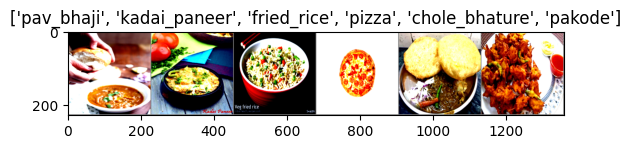

In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:6]),
       title=[class_names[i] for i in labels[:6]])

In [8]:
model = models.resnet18(weights="IMAGENET1K_V1")  # pretrained weights
for param in model.parameters():
    param.requires_grad = False  # freeze backbone

In [9]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [14]:
train_losses, val_losses, val_accs = [], [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / len(val_ds)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

Epoch 1/1: 100%|█████████████████████████████████████████████████████████████████████| 157/157 [02:14<00:00,  1.17it/s]


Epoch [1/1] Train Loss: 0.8691 | Val Loss: 0.8020 | Val Acc: 77.27%


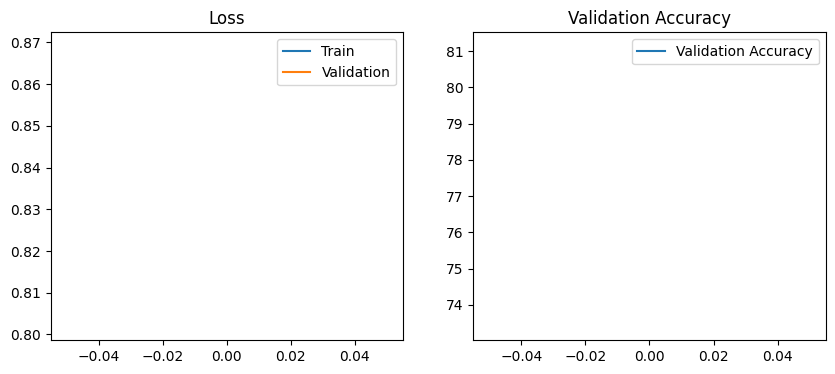

In [15]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

In [16]:
torch.save(model.state_dict(), "indian_food_classifier.pth")
print("✅ Model saved as indian_food_classifier.pth")

✅ Model saved as indian_food_classifier.pth


In [21]:
from PIL import Image

def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        out = model(img_t)
        pred = torch.argmax(out, dim=1)
    print(f"Predicted: {class_names[pred.item()]}")
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[pred.item()]}")
    plt.axis('off')
    plt.show()

Predicted: pizza


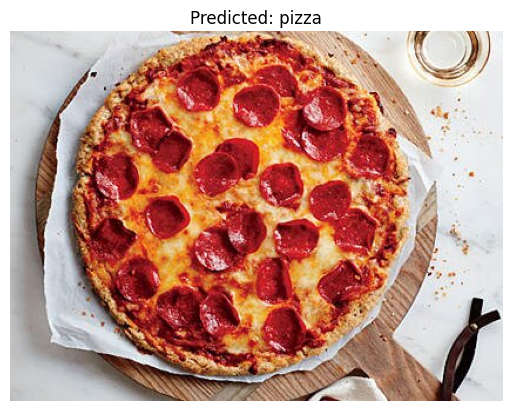

In [24]:
predict_image(r"C:\Users\Panshul\Desktop\panshul\deeplearning\deep-learning\food-classifier\dataset\Food Classification\pizza\015.jpg")